In [1]:
import numpy as np
import os
import time

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras
import keras.applications as kapp

from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten
from keras.optimizers import SGD

from keras.models import Sequential

import png as png
from keras import metrics

print metrics,dir(metrics)
from keras import backend as K

import h5py

def load_dataset(hdf5_in):
    """Load energy+times and pid data."""
    f = h5py.File(hdf5_in, 'r')
    try:
        return f['img_data']['hitimes-x'], f["pid_data"]["pid-x"], f["hadro_data"]["n_neutpions"]
    except KeyError:
        return f['hitimes-x'], f['pid-x']

filename = 'ccprotonpi0_me1A_00.hdf5'

f = h5py.File(filename, 'r')
print f,dir(f),f.keys()
max_evts = 8000
test_evts = 1000

data_x_shp = np.shape(f['img_data']['hitimes-x'])
data_x = np.zeros(data_x_shp, dtype='f')
data_x=f['img_data']['hitimes-x'][:max_evts]
print data_x.shape
data_x_reshape = np.transpose(data_x,(0,2,3,1))
print data_x_reshape.shape

test_x_shp = np.shape(f['img_data']['hitimes-x'])
test_x = np.zeros(test_x_shp, dtype='f')
test_x=f['img_data']['hitimes-x'][max_evts:max_evts+test_evts]
print test_x.shape
test_x_reshape = np.transpose(test_x,(0,2,3,1))
print test_x_reshape.shape

labelraw1_shp=np.shape(f['gen_data']['W'])
labelraw1=np.zeros(labelraw1_shp,dtype='f')
labelraw1=f['gen_data']['W'][:max_evts]

label_shp=np.shape(f['gen_data']['int_type'])
label=np.zeros(label_shp,dtype='f')
label=f['gen_data']['int_type'][:max_evts]

tlabel_shp=np.shape(f['gen_data']['int_type'])
tlabel=np.zeros(tlabel_shp,dtype='f')
tlabel=f['gen_data']['int_type'][max_evts:max_evts+test_evts]

labelraw2_shp=np.shape(f['gen_data']['Q2'])
labelraw2=np.zeros(labelraw2_shp,dtype='f')
labelraw2=f['gen_data']['Q2'][:max_evts]

tlabelraw1_shp=np.shape(f['gen_data']['W'])
tlabelraw1=np.zeros(tlabelraw1_shp,dtype='f')
tlabelraw1=f['gen_data']['W'][:max_evts]

tlabelraw2_shp=np.shape(f['gen_data']['Q2'])
tlabelraw2=np.zeros(tlabelraw2_shp,dtype='f')
tlabelraw2=f['gen_data']['Q2'][:max_evts]


import math
def combinelabel(q2,w):
    if (math.sqrt(q2)>1000 and w > 2000):
        return 1
    else:
        return 0

vcombinelabel = np.vectorize(combinelabel)
#label=vcombinelabel(labelraw2,labelraw1)

num_classes=11

batch_size = 40
testb_size = 40

epochs = 4

Using plaidml.keras.backend backend.


<module 'keras.metrics' from '/Users/jonathanmiller/plaidml-venv/lib/python2.7/site-packages/keras/metrics.pyc'> ['K', 'MAE', 'MAPE', 'MSE', 'MSLE', '__builtins__', '__doc__', '__file__', '__name__', '__package__', 'absolute_import', 'binary_accuracy', 'binary_crossentropy', 'categorical_accuracy', 'categorical_crossentropy', 'cosine', 'cosine_proximity', 'deserialize', 'deserialize_keras_object', 'division', 'get', 'hinge', 'kullback_leibler_divergence', 'logcosh', 'mae', 'mape', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_error', 'mean_squared_logarithmic_error', 'mse', 'msle', 'poisson', 'print_function', 'serialize', 'serialize_keras_object', 'six', 'sparse_categorical_accuracy', 'sparse_categorical_crossentropy', 'sparse_top_k_categorical_accuracy', 'squared_hinge', 'top_k_categorical_accuracy']
<HDF5 file "ccprotonpi0_me1A_00.hdf5" (mode r)> ['_MutableMapping__marker', '__abstractmethods__', '__bool__', '__class__', '__contains__', '__delattr__', '__del

I didn't get a nice data input setup. We are currently using larcv ( http://deeplearnphysics.org/Blog/tutorials/tutorial-01.html ) and caffe (not pycaffe). Caffe you provide it the hdf5 file list and the keys. Larcv also has some nice input algorithms. There is probably an easy way to do this with keras that I did not know.

In [2]:
def scaleimage(a):
    try:
        maxa=np.amax(a)
    except ValueError:
        return a
    if maxa==0:
        return a
    b=a/maxa
    b=b*255
    return b
    
for i in range(10):
    features_i = data_x[i,::]
    #print features_i.shape
    #features_i=np.transpose(features_i,(3,1,2))
    features_i=features_i[0]
    #mag=2
    print features_i.shape
    im = scaleimage(features_i)
    #im = np.repeat(np.repeat(im, mag, axis=0), mag, axis=1)
    #im = np.transpose(features_i,(1,2))
    height, width = im.shape
    #print im,im.shape
    name = str(i)+'testinput.png'
    fpng = open(name, 'wb')
    w = png.Writer(width,height)
    pngWriter = png.Writer(width, height,
                           greyscale=True,
                           alpha=False,
                           bitdepth=16)
    w.write(fpng,np.reshape(im, (-1, width*1)))
    fpng.close()
    
data_x=data_x_reshape
test_x=test_x_reshape



(127, 94)
(127, 94)
(127, 94)
(127, 94)
(127, 94)
(127, 94)
(127, 94)
(127, 94)
(127, 94)
(127, 94)


We can make images as before. The scaling can make us unable or able to see things. Matplotlib is easier for the printing of pictures.

In [3]:
from IPython.display import Image

Image(filename='1testinput.png') 

In [4]:
Image(filename='2testinput.png') 

In [5]:
Image(filename='0testinput.png') 

In [6]:
Image(filename='3testinput.png') 

In [7]:
Image(filename='4testinput.png') 

In [8]:
Image(filename='5testinput.png') 

In [9]:
Image(filename='6testinput.png') 

In [10]:
Image(filename='7testinput.png') 

In [11]:
 Image(filename='8testinput.png') 

In [12]:
 Image(filename='9testinput.png') 

In [13]:
tlabel = keras.utils.to_categorical(tlabel, num_classes)
label = keras.utils.to_categorical(label, num_classes)

This is the translation from list of labels to a label matrix. We definitely could have done something a lot more interesting here if we desired to. I sorta just guessed about classes since I do not know the GENIE interaction types well.

In [14]:
model = Sequential()

firstlayer=Conv2D(8, (3, 3), activation='relu', input_shape=(127, 94, 2))
model.add(firstlayer)
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))


model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Conv2D(16, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(18, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(18, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd,metrics=['categorical_accuracy'])
model.summary()

INFO:plaidml:Opening device "metal_intel(r)_iris(tm)_plus_graphics_640.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 125, 92, 8)        152       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 123L, 90L, 8)      584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30L, 22L, 8L)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30L, 22L, 8L)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28L, 20L, 16)      1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26L, 18L, 16)      2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6L, 4L, 16L)       0         
__________

I only wanted to test things on one file, so this is not really a big data dataset. Because of this I put in some pretty powerful maxpooling and cut down the later dense layers. This is assuredly not want you want to do in general.

In [15]:
data_x = data_x.astype('float32')
test_x = test_x.astype('float32')

data_x = scaleimage(data_x)
test_x = scaleimage(test_x)

In [16]:
firstlayerw = firstlayer.get_weights()[0][:,:,0,:]
for i in range(2):
    name = str(i)+'testinputkernely.png'
    fpng = open(name, 'wb')
    mag=100
    w = png.Writer(3*mag,3*mag)
    im = np.repeat(np.repeat(firstlayerw[:,:,i]+0.5, mag, axis=0), mag, axis=1)
    im=im*255
    #print firstlayerw[:,:,i],firstlayerw[:,:,i].shape
    #print im,im.shape
    pngWriter = png.Writer(width, height,
                           greyscale=True,
                           alpha=False,
                           bitdepth=16)
    w.write(fpng,im)
    fpng.close()

In [17]:
Image(filename='0testinputkernely.png')

In [18]:
Image(filename='1testinputkernely.png')

Same type of kernels as before.

In [19]:
print data_x.shape,label.shape,test_x.shape,tlabel.shape
history=model.fit(data_x, label,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(test_x, tlabel),
                 shuffle=True)

(8000, 127, 94, 2) (8000, 11) (1000, 127, 94, 2) (1000, 11)
Train on 8000 samples, validate on 1000 samples
Epoch 1/4


INFO:plaidml:Analyzing Ops: 211 of 280 operations complete


8000/8000 [==============================] - 119s 15ms/step - loss: 0.0715 - categorical_accuracy: 0.4316 - val_loss: 0.0523 - val_categorical_accuracy: 0.6540
Epoch 2/4
8000/8000 [==============================] - 116s 15ms/step - loss: 0.0535 - categorical_accuracy: 0.6496 - val_loss: 0.0496 - val_categorical_accuracy: 0.6540
Epoch 3/4
8000/8000 [==============================] - 117s 15ms/step - loss: 0.0514 - categorical_accuracy: 0.6560 - val_loss: 0.0487 - val_categorical_accuracy: 0.6540
Epoch 4/4
8000/8000 [==============================] - 117s 15ms/step - loss: 0.0503 - categorical_accuracy: 0.6584 - val_loss: 0.0495 - val_categorical_accuracy: 0.6540


In [20]:
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function
import ROOT as rt

Welcome to JupyROOT 6.14/04


['val_categorical_accuracy', 'loss', 'categorical_accuracy', 'val_loss']
['AddressOf', 'MakeNullPointer', 'PyConfig', 'SetMemoryPolicy', 'SetOwnership', 'SetSignalPolicy', 'TBufferJSON', 'TCanvas', 'TGraph', 'TROOT', 'Template', '_TTabComHook', '__doc__', '__file__', '__name__', 'cout', 'disableJSVis', 'disableJSVisDebug', 'enableJSVis', 'enableJSVisDebug', 'gInterpreter', 'gROOT', 'gSystem', 'kMemoryHeuristics', 'kMemoryStrict', 'kSignalFast', 'kSignalSafe', 'keeppolling', 'module', 'std']
<type 'numpy.ndarray'>
<type 'list'>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


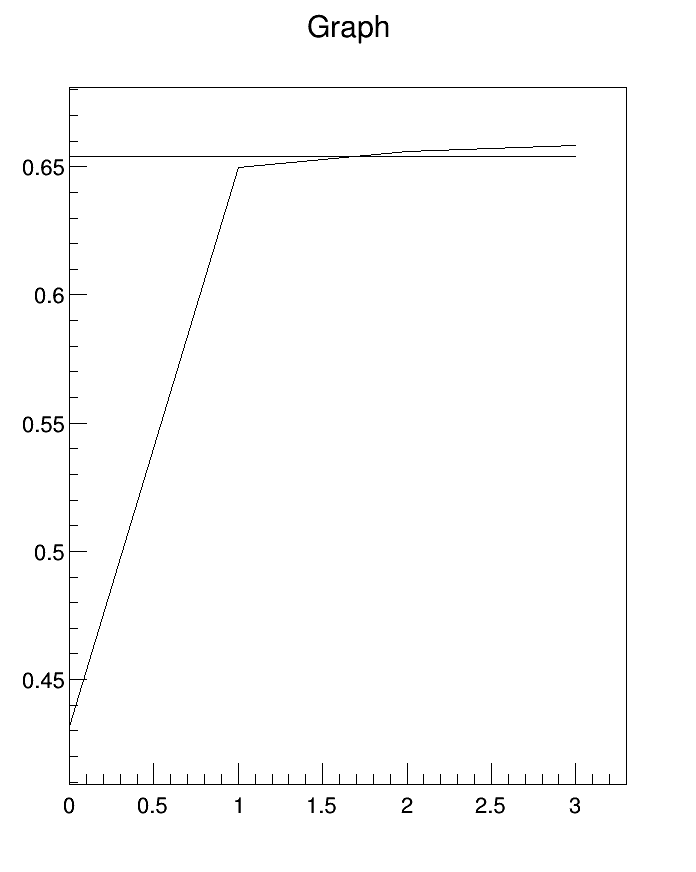

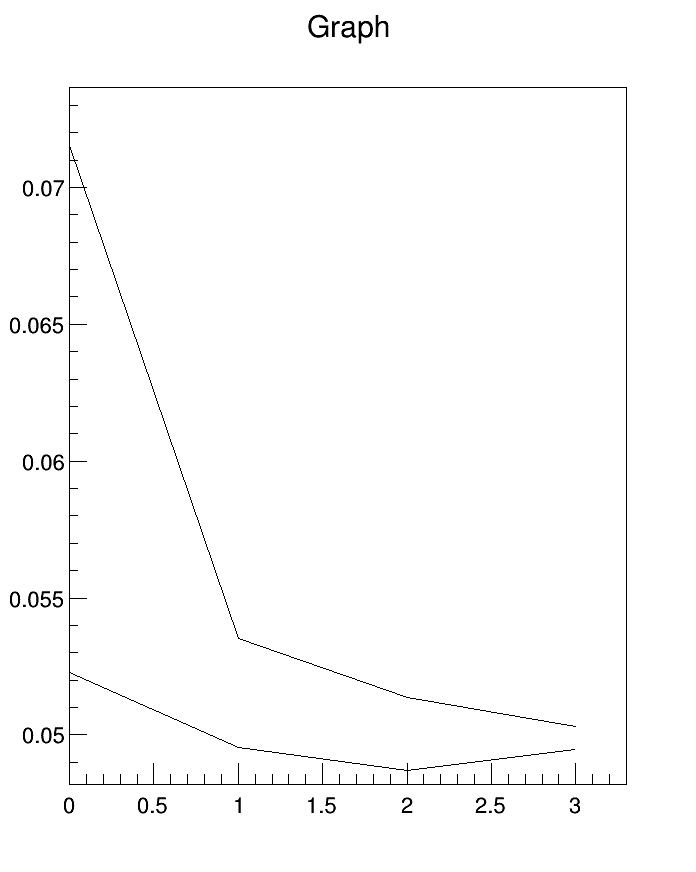

In [47]:
print(history.history.keys())
c1=rt.TCanvas( 'c1', 'c1', 200, 10, 700, 900 )
print dir(rt)
epocharray=np.arange(epochs) 
print type(epocharray)
print type(history.history['categorical_accuracy'])
gr1=rt.TGraph(epochs,epocharray.astype(float),np.asarray(history.history['categorical_accuracy'],float))
gr2=rt.TGraph(epochs,epocharray.astype(float),np.asarray(history.history['val_categorical_accuracy'],float))
gr3=rt.TGraph(epochs,epocharray.astype(float),np.asarray(history.history['loss'],float))
gr4=rt.TGraph(epochs,epocharray.astype(float),np.asarray(history.history['val_loss'],float))

gr1.Draw("")
gr2.Draw("same")
c1.Modified()
c1.Update()
c2=rt.TCanvas( 'c2', 'c2', 200, 10, 700, 900 )
gr3.Draw("")
gr4.Draw("same")
c2.Modified()
c2.Update()

rt.gROOT.GetListOfCanvases().Draw()

Even in only 3 epochs we see some reasonable behavior. There are more parameters than data so we don't expect this to be a great application (also we have too many classes).

In [22]:
spec_x = data_x[:9]
for i in range(3):
    features_i = spec_x[i,::]
    print features_i.shape
    features_i=np.transpose(features_i,(2,0,1))
    print features_i.shape
    features_i=features_i[0]
    #mag=2
    print features_i.shape
    im = scaleimage(features_i)
    #im = np.repeat(np.repeat(im, mag, axis=0), mag, axis=1)
    #im = np.transpose(features_i,(1,2))
    height, width = im.shape
    #print im,im.shape
    name = str(i)+'testinputpic.png'
    fpng = open(name, 'wb')
    w = png.Writer(width,height)
    pngWriter = png.Writer(width, height,
                           greyscale=True,
                           alpha=False,
                           bitdepth=16)
    w.write(fpng,np.reshape(im, (-1, width*1)))
    fpng.close()
    


(127, 94, 2)
(2, 127, 94)
(127, 94)
(127, 94, 2)
(2, 127, 94)
(127, 94)
(127, 94, 2)
(2, 127, 94)
(127, 94)


In [23]:
Image(filename='0testinputpic.png')

In [24]:
Image(filename='1testinputpic.png')

In [25]:
Image(filename='2testinputpic.png')

In [26]:
layer_outs = functor([spec_x, 1.])

for i in range(7):
    print spec_x.shape
    features_i = layer_outs[0][2]*7
    #print features_i.shape
    #mag=7
    #print features_i
    #features_i = np.repeat(np.repeat(features_i, mag, axis=0), mag, axis=1)
    im = np.transpose(features_i,(2,1,0))
    #print im.shape,im[i].shape
    #im = np.transpose(im[0],(2,1,0))
    height, width =im[i].shape
    name = str(i)+'testoutputpic.png'
    fpng = open(name, 'wb')
    #print width,height
    w = png.Writer(width,height)
    imi = np.reshape(im[i], (-1, width*1))
    #print imi,imi.shape
    pngWriter = png.Writer(width, height,
                           greyscale=True,
                           alpha=False,
                           bitdepth=16)
    #w.write(fpng,np.reshape(im[i], (-1, height*1)))
    w.write(fpng,imi)


    fpng.close()

(9, 127, 94, 2)
(9, 127, 94, 2)
(9, 127, 94, 2)
(9, 127, 94, 2)
(9, 127, 94, 2)
(9, 127, 94, 2)
(9, 127, 94, 2)


In [27]:
Image(filename='0testoutputpic.png')

In [28]:
Image(filename='1testoutputpic.png')

In [29]:
Image(filename='2testoutputpic.png')

In [30]:
Image(filename='3testoutputpic.png')

In [31]:
Image(filename='4testoutputpic.png')

In [32]:
Image(filename='5testoutputpic.png')

In [33]:
Image(filename='6testoutputpic.png')

Probably every image should be scaled, as you can see things better or less well as you adjust the scaling. I would say that it is a good idea to adjust this but I think you should just do better individual scaling. Or use matplotlib.

In [34]:
for i in range(7):
    print spec_x.shape
    features_i = layer_outs[1][2]*16
    #print features_i.shape
    #mag=7
    #print features_i
    #features_i = np.repeat(np.repeat(features_i, mag, axis=0), mag, axis=1)
    im = np.transpose(features_i,(2,1,0))
    #print im.shape,im[i].shape
    #im = np.transpose(im[0],(2,1,0))
    height, width =im[i].shape
    name = str(i)+'testoutputpic2.png'
    fpng = open(name, 'wb')
    #print width,height
    w = png.Writer(width,height)
    imi = np.reshape(im[i], (-1, width*1))
    #print imi,imi.shape
    pngWriter = png.Writer(width, height,
                           greyscale=True,
                           alpha=False,
                           bitdepth=16)
    #w.write(fpng,np.reshape(im[i], (-1, height*1)))
    w.write(fpng,imi)


    fpng.close()

(9, 127, 94, 2)
(9, 127, 94, 2)
(9, 127, 94, 2)
(9, 127, 94, 2)
(9, 127, 94, 2)
(9, 127, 94, 2)
(9, 127, 94, 2)


In [35]:
Image(filename='0testoutputpic2.png')

In [36]:
Image(filename='1testoutputpic2.png')

It is hard to see what they are identifying. Probably a better network, better image production (we use matplotlib usually) would make visualizing these more useful and interesting.

In [37]:
print dir(layer_outs)

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__delslice__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getslice__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__setslice__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']


In [38]:
print layer_outs[6][2]

[[[0.71118724 0.26403084 0.         0.16638239 1.0112139  0.5256103
   0.7171944  0.67081475 0.05226527 0.34907988 0.84166765 0.
   0.         1.1668612  0.         0.56146365]
  [0.9689013  0.22939661 0.         0.22258319 1.1979908  0.51505196
   0.6898832  0.63476825 0.04128312 0.27963686 0.69162905 0.
   0.         1.3464022  0.         0.78114516]
  [0.9514215  0.31035024 0.         0.23639756 1.2638535  0.5874531
   0.6320159  0.64061964 0.         0.14794034 0.569339   0.
   0.         1.4001259  0.         0.7888814 ]
  [0.87119824 0.23117213 0.         0.24453029 0.8434843  0.632966
   0.5079305  0.66733575 0.         0.17965001 0.56796783 0.
   0.         1.4282533  0.         0.74619216]]

 [[1.1102644  0.29123655 0.         0.18839294 0.9545834  0.5759679
   0.7098834  0.7715739  0.01583817 0.09577923 0.8834745  0.
   0.         1.1357346  0.         0.7961876 ]
  [0.8769481  0.30303708 0.         0.19832586 1.2049999  0.615261
   0.47333434 0.753478   0.         0.27542514

We can pull the features from any layer, and put them into some other algorithm (like a SVM).

In [39]:
print layer_outs[9][2]

[3.0488317 0.        0.        3.6570563 0.7280952 1.221029  1.1892599
 0.        0.        0.        0.        3.9854808 0.        0.
 0.        0.        0.        0.       ]


In [40]:
print layer_outs[12][2]

[1.6229644e-05 9.6885659e-02 9.0226270e-02 7.9564416e-01 7.1975952e-03
 1.6967337e-04 3.5854671e-04 1.5474648e-03 6.9587515e-03 2.0728965e-04
 7.8835193e-04]


In [41]:
print layer_outs[12][1]

[0.003018   0.15166894 0.25447926 0.4992115  0.01539084 0.00200932
 0.0073177  0.0073752  0.03821527 0.00475492 0.01655912]


In [46]:
print layer_outs[12][0]
print layer_outs[12][3]
print layer_outs[12][4]
print layer_outs[12][5]
print layer_outs[12][6]





[1.0969518e-06 5.5155981e-02 2.6412654e-01 6.7810541e-01 1.6935100e-04
 5.0272661e-07 1.8022094e-05 9.4269351e-05 2.1418051e-03 1.0193866e-05
 1.7684656e-04]
[2.3932991e-05 1.3675278e-01 1.0053839e-01 7.4949986e-01 4.4130110e-03
 1.2339579e-04 6.5103098e-04 1.6946272e-03 5.2937390e-03 8.6248503e-05
 9.2297222e-04]
[7.1059503e-07 1.0139236e-01 7.6369308e-02 8.1298548e-01 6.5893205e-03
 2.0892921e-05 5.9665297e-05 2.1158201e-04 2.0140461e-03 1.3530289e-04
 2.2129391e-04]
[7.5136995e-07 7.8306876e-02 2.6968557e-01 6.4986414e-01 3.2385284e-04
 5.7185383e-07 1.8122413e-05 8.7689943e-05 1.5990022e-03 6.1414294e-06
 1.0731117e-04]
[1.2489577e-03 1.1736146e-01 7.2583966e-02 7.5407159e-01 5.3891321e-03
 4.5324033e-04 1.2544725e-03 5.4921028e-03 3.7965775e-02 1.0946839e-03
 3.0845616e-03]


In [44]:
print label[:9]

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


I tend to think that it is just generally going for 3 and so is generally correct. But you can see that you get non-3 predictions and can use the output.